# PHYS3009 Project: Modelling the Emission

Name:

Student No.:

total marks: 33

## Purpose of this Project

In this project you will learn how the energy spectrum from an observation can be used to study the astrophysical mechanisms at work in the source. This project will make use of the non-thermal radiation mechanisms learned in PHYS3008 and the data sets created in PHYS3009.

You will need the data files you have created in the TeV Astronomy project, ```RXJ1713_spectrum.ecsv```, and in the Fermi/LAT project, ```4fgl_j1713.5-3945e_sed.ecsv```. Place these files in the working directory of this notebook. If you are working on mybinder you will need to upload your own data file: Go to the jupyter home page (not this notebook, it is in a different tab or window of your browser) and click on Upload in the top-right corner.

## Load and test the modules

As usual we will start with importing the necessary modules and we check the versions of ```naima``` and ```gammapy```.

In [ ]:
import gammapy

gammapy.__version__

In [ ]:
from astropy.table import Table

from astropy import units as u

from astropy import constants as c

import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
from gammapy.estimators import FluxPoints

from gammapy.datasets import Datasets, FluxPointsDataset

from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    LogParabolaSpectralModel,
    SkyModel,
    NaimaSpectralModel,
    CompoundSpectralModel
)

import operator

from gammapy.modeling import Fit

In [ ]:
fit = Fit()

## Additional Parameters and Settings

We have measured the gamma-ray and radio flux on Earth and now we want to model the emission in the source. We will need the distance to the source. The distance cannot be measured directly from gamma rays or radio, and sometimes the distance is not known. Good for us that the distance to RX J1713 is known.

In [ ]:
distance = 1*u.kpc

## Loading the Data

### Reading the H.E.S.S. points

We have produced the data points with gammapy, so it should be easy to load them again. If your file has a different name then change the filename in the next cell.

In [ ]:
hesspoints = FluxPoints.read('RXJ1713_spectrum.ecsv')

We see that everything is there what we have produced last time.

In [ ]:
hesspoints.plot()

#plt.savefig('Modelling_HESS_spectrum.png')

Expected output:

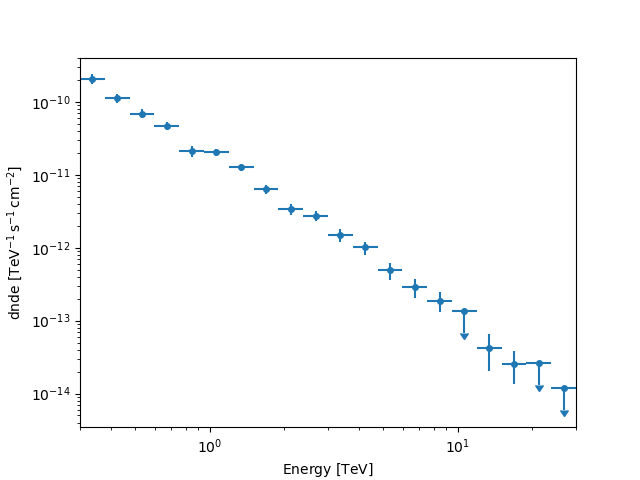

Now we create a data set which combines the flux points and a model we want to fit. We should use the same model as in the project before.

In [ ]:
hesspoints_ds = FluxPointsDataset(data = hesspoints,
                                  models = SkyModel(spectral_model=ExpCutoffPowerLawSpectralModel()),
                                  name = 'H.E.S.S.'
                                 )

Next we fit the model to the flux points.

In [ ]:
fit.run(hesspoints_ds)

Make sure that the optimization terminated successfully. These numbers are a bit different then what we have found in the direct fit to the data. This is due to the extra step of generating flux points and refitting these points. But within errors this agrees very well.

In [ ]:
hesspoints_ds.plot_fit()

#plt.savefig('Modelling_HESS_Dataset.png')

Epected output:

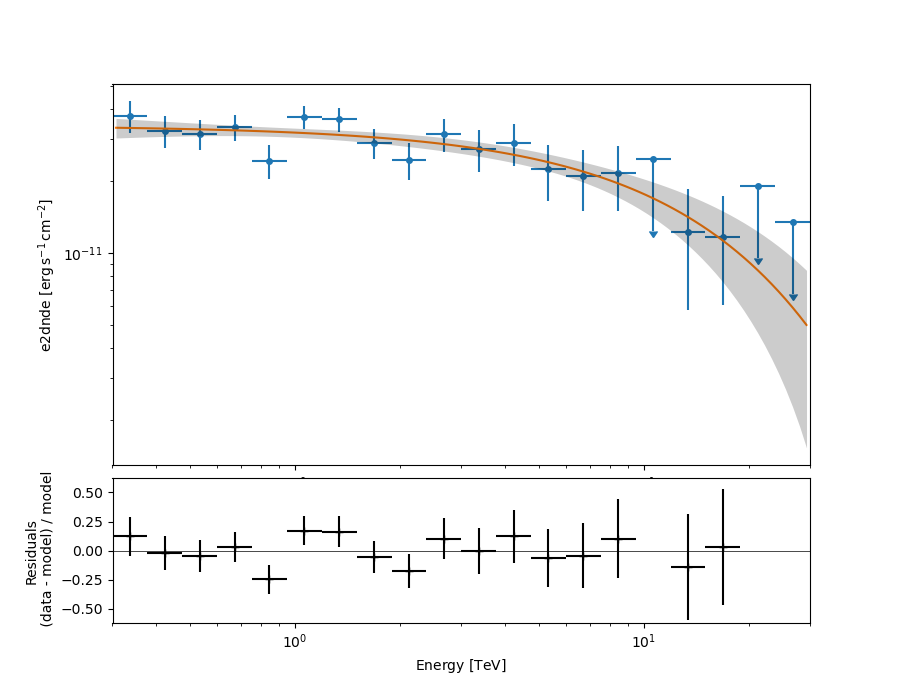

### Reading the Fermi/LAT Data Points

**Exercise:**

Let's do the same with the Fermi/LAT data points. Place your Fermi/LAT file in your working directory or on mybinder and load the flux points.

In [ ]:
# your code here

fermipoints = ...

In [ ]:
fermipoints.plot()

#plt.savefig('Modelling_Fermi_spectrum.png')

Expected output:

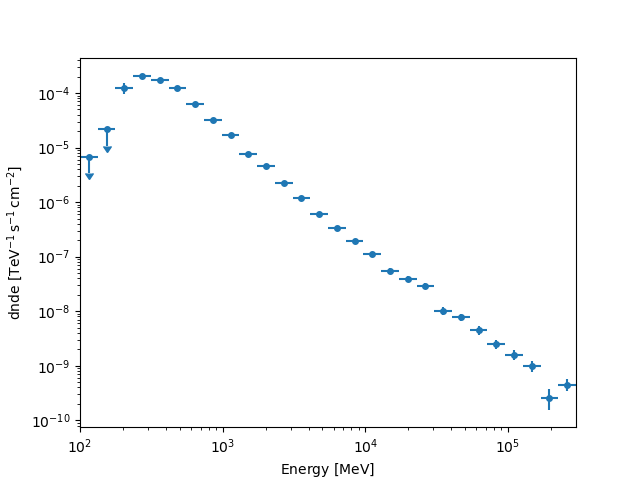

Your plot may look slightly different. 

Output produced: **[1 mark]**

**Exercise:**

Create a data set for these points and add a LogParabola spectral model with a reference energy of 8922 MeV as spectral model. Name the model ```'Fermi/LAT'```.

In [ ]:
# your code here

fermipoints_ds = ...

In [ ]:
print(fermipoints_ds)

Expected output:

```
FluxPointsDataset
-----------------

  Name                            : Fermi/LAT 

  Number of total flux points     : 28 
  Number of fit bins              : 26 

  Fit statistic type              : chi2
  Fit statistic value (-2 log(L)) : 4522.55

  Number of models                : 1 
  Number of parameters            : 4
  Number of free parameters       : 3

  Component 0: SkyModel
  
    Name                      : 08Cb2aLe
    Datasets names            : None
    Spectral model type       : LogParabolaSpectralModel
    Spatial  model type       : 
    Temporal model type       : 
    Parameters:
      amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (TeV s cm2)
      reference             (frozen):   8922.000       MeV         
      alpha                         :      2.000   +/-    0.00             
      beta                          :      1.000   +/-    0.00          
```

Some numbers might be different.

**[3 marks]**

In [ ]:
fermipoints.plot(energy_power=2)

The data points below 5 GeV look wrong. To keep it simple, we will not use the bins below 5 GeV in the fits. We will use a mask_fit for that.

In [ ]:
fermipoints_ds.mask_fit = np.logical_and(fermipoints_ds.data.energy_min > 5*u.GeV, 
                                         fermipoints_ds.mask)

***Exercise***

Now run the fit, check for sucess and plot the fit.

In [ ]:
# your code here

Expected output:

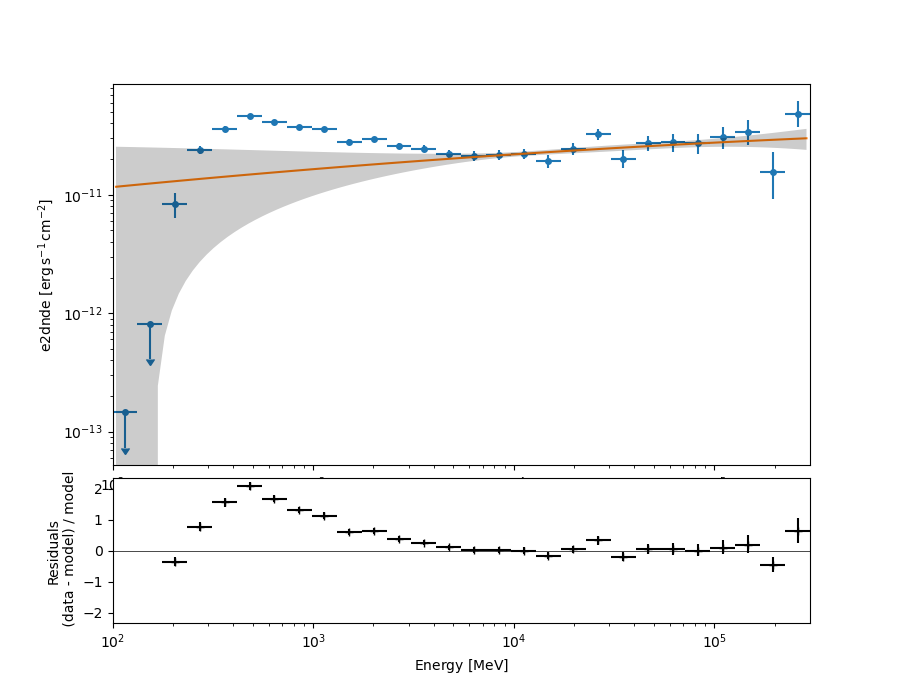

For energies larger than 5 GeV the model fits well the data.

Succesful fit and plot created:
**[3 marks]**

### X-Ray Data

We will need X-Ray data to model the synchrotron radiation. We can find the data points in this publication:

https://iopscience.iop.org/article/10.1086/591020/fulltext/

There are measurements with two different instruments, XIS and HXD. For both instruments we have the energy range, the flux and its error and the spectral index. We will create two separate data sets.

In [ ]:
table_XIS = Table()

table_XIS['e_min'] = [0.4*u.keV]
table_XIS['e_max'] = [12*u.keV]
table_XIS['eflux'] = [7.65e-10*u.Unit('erg s-1 cm-2')]
table_XIS['eflux_err'] = [0.03e-10*u.Unit('erg s-1 cm-2')]

table_XIS.meta["SED_TYPE"] = 'eflux'

In [ ]:
XISpoints = FluxPoints.from_table(table_XIS, 
                                  reference_model=PowerLawSpectralModel(index=2.39))

In [ ]:
XISpoints_ds = FluxPointsDataset(data = XISpoints,
                                 name = 'Suzaku (XIS)'
                                )

In [ ]:
table_HXD = Table()

table_HXD['e_min'] = [12*u.keV]
table_HXD['e_max'] = [40*u.keV]
table_HXD['eflux'] = [1.17e-10*u.Unit('erg s-1 cm-2')]
table_HXD['eflux_err'] = [0.03e-10*u.Unit('erg s-1 cm-2')]

table_HXD.meta["SED_TYPE"] = 'eflux'

In [ ]:
HXDpoints = FluxPoints.from_table(table_HXD, 
                                  reference_model=PowerLawSpectralModel(index=3.2))

In [ ]:
HXDpoints_ds = FluxPointsDataset(data = HXDpoints,
                                 name = 'Suzaku (HXD)'
                                )

### Radio Data

We will also need radio data. We use the measurements found in the following paper:

https://www.aanda.org/articles/aa/pdf/2009/37/aa11556-08.pdf

In [ ]:
frequency = u.Quantity(np.array([1.4])*u.GHz)
Ftot = u.Quantity(np.array([24])*u.Jy)
Ftot_err = u.Quantity(np.array([2])*u.Jy)

We have the photon frequencies, but we want the energy.

In [ ]:
Ephoton_radio = (frequency*c.h).to(u.TeV)

The unit Jansky is flux per frequency. We need the flux per photon energy, so we divide by Planck's constant. 
We have the energy flux, but we want the photon flux, so we divide by the photon energy.

In [ ]:
Ftot = Ftot/c.h/Ephoton_radio
Ftot_err = Ftot_err/c.h/Ephoton_radio

In [ ]:
Ftot = Ftot.to(1/u.cm**2/u.s/u.TeV)
Ftot_err = Ftot_err.to(1/u.cm**2/u.s/u.TeV)

Let's make a table of the data points.

In [ ]:
radio_table = Table([Ephoton_radio.to(u.TeV), Ftot, Ftot_err], 
                    names = ['e_ref', 'dnde', 'dnde_err'])

radio_table.meta['SED_TYPE'] = 'dnde'

In [ ]:
radiopoints = FluxPoints.from_table(radio_table)

In [ ]:
radiopoints_ds = FluxPointsDataset(data = radiopoints,
                                 name = 'ATCA'
                                )

## Plot the Data Points

All our data points cover an energy range from about $10^{-18}$ TeV to $100$ TeV. Let's save this in an array for later use.

In [ ]:
energy_bounds = [1e-18, 100] * u.TeV

Now we create a function to plot all our data points. We will make use of it several times.

In [ ]:
def PlotPoints() :
    
    ax = plt.subplot()

    ax.xaxis.set_units(u.Unit('TeV'))

    kwargs = {'ax': ax, 
              'sed_type': 'e2dnde',
             }

    fermipoints.plot(label = 'Fermi/LAT', **kwargs)
    hesspoints.plot(label = 'H.E.S.S.', **kwargs)
    XISpoints.plot(label = 'Suzaku (XIS)', **kwargs)
    HXDpoints.plot(label = 'Suzaku (HXD)', **kwargs)
    radiopoints.plot(label = 'ATCA', **kwargs)

    ax.set_xlim(energy_bounds)

    ax.set_ylim(5e-15)
    
    plt.legend()

In [ ]:
PlotPoints()

#plt.savefig('Modelling_AllPoints.png')

Expected output:

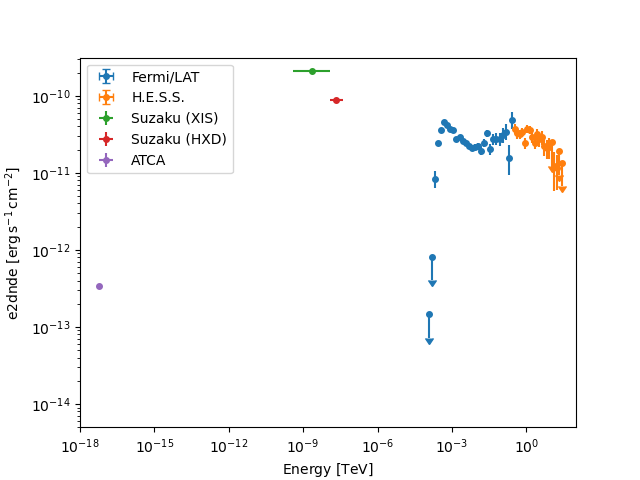

## Fit a Simple Model to the Gamma-Ray Data

We start with fitting a power law with exponential cut-off to the gamma-ray data.will

**Exercise**

Create a spectral model for a power law with exponential cut-off which has default parameters of $1 \times 10^{-11}\,\mathsf{cm}^{-2}\mathsf{s}^{-1}\mathsf{TeV}^{-1}$ for the amplitude, spectral index of $2$ and a cut-off energy of $10$ TeV. The reference energy should be at $1$ TeV.

In [ ]:
# your code here

spectral_model = ...

In [ ]:
print(spectral_model)

Expected output:

```
ExpCutoffPowerLawSpectralModel

  type      name     value         unit      ... max frozen is_norm link
-------- --------- ---------- -------------- ... --- ------ ------- ----
spectral     index 2.0000e+00                ... nan  False   False     
spectral amplitude 1.0000e-11 TeV-1 s-1 cm-2 ... nan  False    True     
spectral reference 1.0000e+00            TeV ... nan   True   False     
spectral   lambda_ 1.0000e-01          TeV-1 ... nan  False   False     
spectral     alpha 1.0000e+00                ... nan   True   False 
```

Model created with correct parameters: **[1 mark]**

We will need the spectral_model in a SkyModel for the fit. Please note that we give a name to our SkyModel. The name will be used later in the plots.ray

In [ ]:
model_expPL = SkyModel(spectral_model=spectral_model, name='expPL')

We want to fit this model two both gamma-ray data sets. We combine both data sets into one:

In [ ]:
gamma_datasets = Datasets([fermipoints_ds, hesspoints_ds])

***Exercise***

Assign the model ```model_expPL``` to the data set ```gamma_datasets``` and run the fit. Make sure that the fit converges.

In [ ]:
# your code here

Model assigned and sucessful fit: **[2 marks]**

Now we want to plot all our data points and the best-fit model. We create another function to plot the model:

In [ ]:
def PlotModel(model, name = None) :

    if name is None :
        name = model.name
    
    model = model.spectral_model
    
    model.plot(sed_type = 'e2dnde',
               energy_bounds=energy_bounds,
               label = name
              )
    model.plot_error(sed_type = 'e2dnde',
                     energy_bounds=energy_bounds
                    )
    
    plt.legend()

Now we can plot data points and model together.

In [ ]:
PlotPoints()
PlotModel(model_expPL)

#plt.savefig('Modelling_GammaFit.png')

Expected output: 

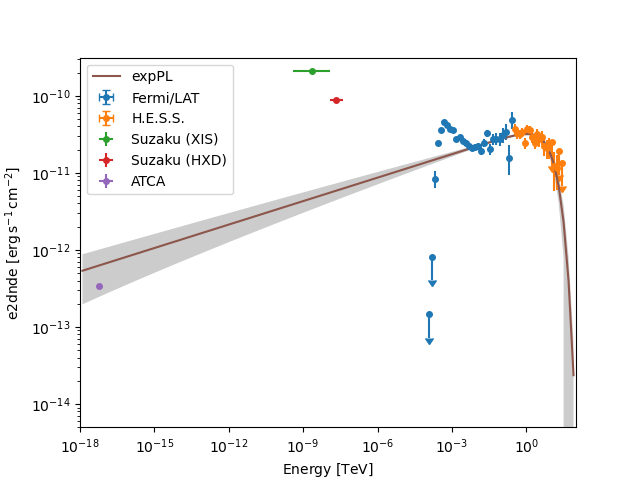

## Fitting Astrophysical Models

So far, we have fitted power laws (with and without cut-off) to our data. We just described the shape of the gamma-ray energy spectrum. Now we want to fit astrophysical models and measure astrophysical parameters.

### Particle Distributions

We will take a population of protons or electrons and model the gamma-ray emission from these particles. The energy spectrum of these particles should follow a power law with exponential cut-off. Let's create spectra for electrons and protons. 

We will use the ```ExponentialCutoffPowerLaw``` functions from ```naima``` as we have done in PHYS3008. This is a power law with a super-exponential cut-off,
$$
\frac{dN}{dE} = A \times \left( \frac{E}{E_0} \right) ^{-\alpha} \times \exp \left( - \left(\frac{E}{E_\mathsf{cutoff}}\right)^\beta \right),
$$
where we will set $\beta = 1$ to obtain a normal exponential cut-off. We will set all parameters to some meaningful values.

Here is the parametrisation of the electron distribution.

In [ ]:
# electron distribution
electrons = naima.models.ExponentialCutoffPowerLaw(amplitude = 1e45 / u.eV,
                                                   e_0 = 0.1 * u.TeV,
                                                   alpha = 2,
                                                   e_cutoff = 1 * u.TeV,
                                                   beta = 1)

**Exercise:**

Make a proton distribution. The reference energy, ```e_0``` should be 1 TeV and the cut-off energy, ```e_cutoff```, should be 100 TeV. The remaining parameters should be the same as above.

In [ ]:
# your code here

protons = ...

Correct model created: **[2 mark]**

### Hadronic Model

In a hadronic model the protons collide with ambient material. The neutral pions produced in these collisions decay into gamma rays. The only parameter in this process is the target particle density $n$. We will set $n$ to one particle per cubic-centimetre.

In [ ]:
n = 1./ u.cm**3

Next we create a model for pion decays from ```naima```. The paramters are the proton distribution and the density.

In [ ]:
hadronic = naima.models.PionDecay(protons, n)

We set the total energy in protons to a reasonable value. If the fit later on does not converge then you may need to adjust this value here.

In [ ]:
hadronic.set_Wp(1e50*u.erg)

This is a ```naima``` model, and we want to include it in ```gammapy```. There is a ```NaimaSpectralModel``` for this. We will also add the distance to the source. This will be the spectral model inside a SkyModel. We name the model ```'pion decay'```.

In [ ]:
model_hadronic = SkyModel(
    spectral_model=NaimaSpectralModel(
        hadronic, distance=distance),
    name = 'pion decay'
    )

Let's print all the parameters:

In [ ]:
model_hadronic.parameters.to_table()

All parameters are free for the fit. We cannot fit the reference energy ```e_0``` we must freeze it.

In [ ]:
model_hadronic.parameters['e_0'].frozen = True

We could fit the ```beta``` parameter as well. But then we will need to check if it is significantly different from 1. Let's keep this parameter at 1 and freeze it.

In [ ]:
model_hadronic.parameters['beta'].frozen = True

In [ ]:
model_hadronic.parameters.to_table()

In [ ]:
PlotPoints()
PlotModel(model_hadronic)

Our model is already close to the data. But we need to fit the model to the data.

***Exercise***

Fit the hadronic model to the gamma-ray data. Use the Dataset called ```gamma_datasets``` for this.

In [ ]:
# your code here

You may get a message ```Optimization terminated successfully., but uncertainties are unreliable.``` You can ignore this as long as the CovarianceResult terminates with ```Hesse terminated successfully.```

You may get an error ```Optimization failed. Estimated distance to minimum too large.``` or ```Optimization failed. Call limit was reached.```. This would be clearly a failed fit. Often it helps to run the fit again without reinitialising the parameters.

Sucessful fit: **[2 marks]**

In [ ]:
PlotPoints()
PlotModel(model_hadronic)

#plt.savefig('Modelling_HadronicFit.png')

Expected output:

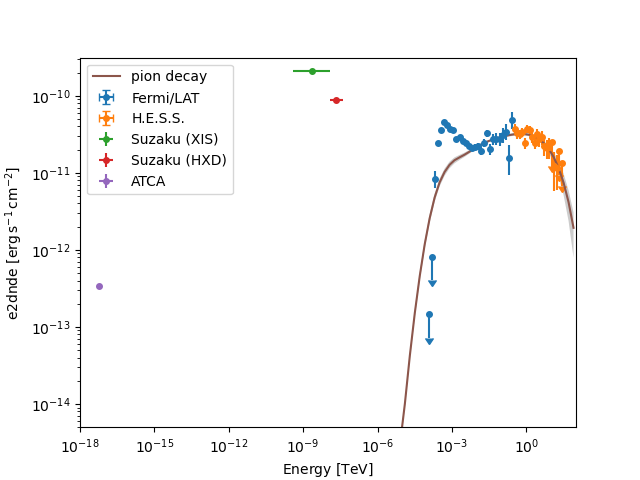

One interesting result is the cut-off of the proton spectrum:

In [ ]:
print('Cut-off energy: E_cut = ({:3.1f} +/- {:2.1f}) {}'.format(
                                                model_hadronic.parameters['e_cutoff'].value,
                                                model_hadronic.parameters['e_cutoff'].error,
                                                model_hadronic.parameters['e_cutoff'].unit))

Another scientific question is about the total energy in protons. We can get this number from the hadronic model:

In [ ]:
hadronic.Wp

### Inverse Compton Emission

***Exercise***

Now we want to fit an Inverse Compton model to the gamma-ray data. Use only CMB for the photon fields. Create an InverseCompton object (```naima.models.InverseCompton```) which uses the electrons defined above, the CMB for the photon fields and a minimum energy of 511 keV.

In [ ]:
## your code here

IC = ...

Object created: **[3 marks]**

We set the total energy in electrons to $10^{48}$ erg.

In [ ]:
IC.set_We(1e48*u.erg)

Now we create a SkyModel and freeze the ```e_0``` and ```beta``` parameters. We set the distance to the value defined in the beginning.

In [ ]:
model_IC = SkyModel(spectral_model=NaimaSpectralModel(IC, distance=distance),
                    name = 'inverse Compton')

In [ ]:
model_IC.parameters['e_0'].frozen = True
model_IC.parameters['beta'].frozen = True

***Exercise***

Fit the IC model to the gamma-ray data points.

In [ ]:
## your code here

Succesful fit: **[2 marks]**

In [ ]:
PlotPoints()
PlotModel(model_IC)

#plt.savefig('Modelling_IcFit.png')

Expected output:

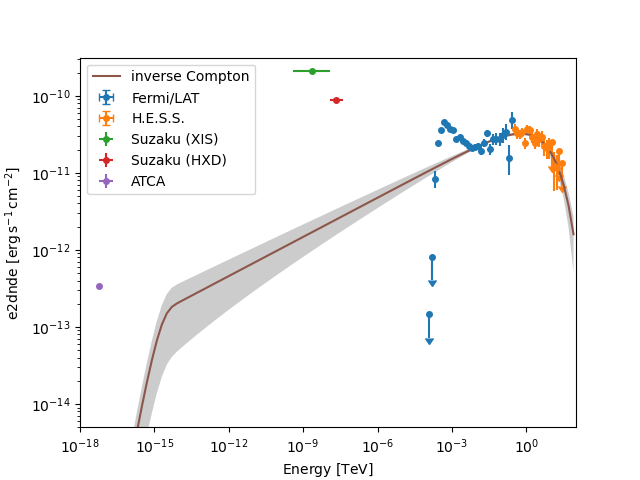

### Synchroton emission

Synchrotron emission requires a magnetic field. Let's start with a default value of $100\,\mu\mathsf{G}$.

In [ ]:
B = 100 * u.microGauss

***Exercise***

Create a Synchrotron model. Use ```naima.models.Synchrotron``` with the electrons defined above, the magnetic field defined above and a minimum energy off 511 keV. Your ```model_sync``` should be a SkyModel with the predefined distance. Freeze the parameters ```e_0``` and ```beta```. Your ```model_sync``` should be a SkyModel. The name of the model should be ```'synchrotron'```.

In [ ]:
## your code here

model_sync = ...

In [ ]:
print(model_sync)

Expected output:

```
SkyModel

  Name                      : synchrotron
  Datasets names            : None
  Spectral model type       : NaimaSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   5.20e+37   +/- 0.0e+00 1 / eV      
    e_0                   (frozen):      0.100       TeV         
    alpha                         :      2.661   +/-    0.00             
    e_cutoff                      :     61.626   +/-    0.00 TeV         
    beta                  (frozen):      1.000                   
    B                             :    100.000   +/-    0.00 uG          
```

Correct model created: **[4 marks]**will

In [ ]:
PlotPoints()
PlotModel(model_sync)
PlotModel(model_IC)

plt.ylim(1e-16, 1e-7)

The synchrotron model largely overestimates the radio and X-ray points. We will now freeze all parameters except for the magnetic field.

In [ ]:
model_sync.parameters.freeze_all()

In [ ]:
model_sync.parameters['B'].frozen = False

In [ ]:
model_sync.parameters.to_table()

We now fit this model to the X-ray points.

In [ ]:
Xray_datasets = Datasets([XISpoints_ds, HXDpoints_ds])

In [ ]:
Xray_datasets.models = model_sync

In [ ]:
fit.run(Xray_datasets)

In [ ]:
PlotPoints()
PlotModel(model_sync)
PlotModel(model_IC)

We still overestimate the radio flux. 

We can try to fit all parameters of the synchrotron model to the radio and X-ray points.

In [ ]:
sync_datasets = Datasets([radiopoints_ds, XISpoints_ds, HXDpoints_ds])

In [ ]:
model_sync.parameters.unfreeze_all()
model_sync.parameters['e_0'].frozen = True
model_sync.parameters['beta'].frozen = True

In [ ]:
sync_datasets.models = model_sync

In [ ]:
fit.run(sync_datasets)

In [ ]:
PlotPoints()
PlotModel(model_sync)

#plt.savefig('Modelling_SyncFit.png')

Expected output:

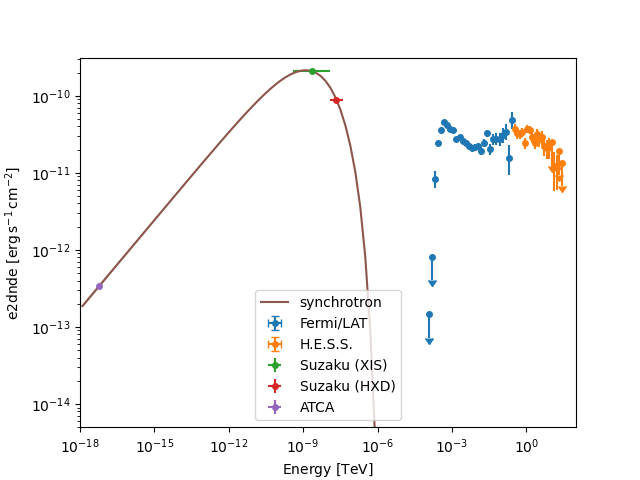

This worked well. The fit changed the parameters of the electron spectrum. Let's now see how the IC emission looks like for this parameter set. We copy the synchrotron parameters to the IC model.

In [ ]:
model_IC.spectral_model.amplitude.value = model_sync.spectral_model.amplitude.value
model_IC.spectral_model.alpha.value = model_sync.spectral_model.alpha.value
model_IC.spectral_model.e_cutoff.value = model_sync.spectral_model.e_cutoff.value
model_IC.spectral_model.beta.value = model_sync.spectral_model.beta.value

In [ ]:
PlotPoints()
PlotModel(model_sync)
PlotModel(model_IC)

Now we are overshooting the gamma-ray data.

### Combine all Data Sets

In the next steps we will fit models to all our data. We create Dataset called ```all_datasets``` that contains all our individual data.

In [ ]:
all_datasets = gamma_datasets.copy()

In [ ]:
all_datasets.extend(sync_datasets)

In [ ]:
all_datasets.names

### Leptonic Model

We now create a model that is the sum of the synchrotron radiation and inverse-Compton emission.

In [ ]:
model_leptonic = SkyModel(
    spectral_model=CompoundSpectralModel(model_sync.spectral_model,
                                         model_IC.spectral_model,
                                         operator.add),
    name = 'leptonic model'
)

In [ ]:
model_leptonic.parameters.to_table().show_in_notebook()

We have 11 parameters, but need only 6: ```amplitude```, ```alpha``` and ```e_cutoff``` of the electrons, and the magnetic field. ```e_0``` and ```beta``` for the electrons should be frozen.

In the next cell we set the parameters of the synchrotron and inverse-Compton model equal. They will always have the same value.

In [ ]:
model_leptonic.spectral_model.model2.amplitude = model_leptonic.spectral_model.model1.amplitude
model_leptonic.spectral_model.model2.alpha = model_leptonic.spectral_model.model1.alpha
model_leptonic.spectral_model.model2.beta = model_leptonic.spectral_model.model1.beta
model_leptonic.spectral_model.model2.e_cutoff = model_leptonic.spectral_model.model1.e_cutoff

In [ ]:
all_datasets.models = model_leptonic

In [ ]:
PlotPoints()
PlotModel(model_leptonic)

**Exercise**

Run the fit and make sure that it is succesful.

In [ ]:
# your code here

Fit succeeded: **[1 mark]**

In [ ]:
PlotPoints()

PlotModel(model_IC)
PlotModel(model_sync)

#plt.savefig('Modelling_LeptonicFit.png')

Expected output:

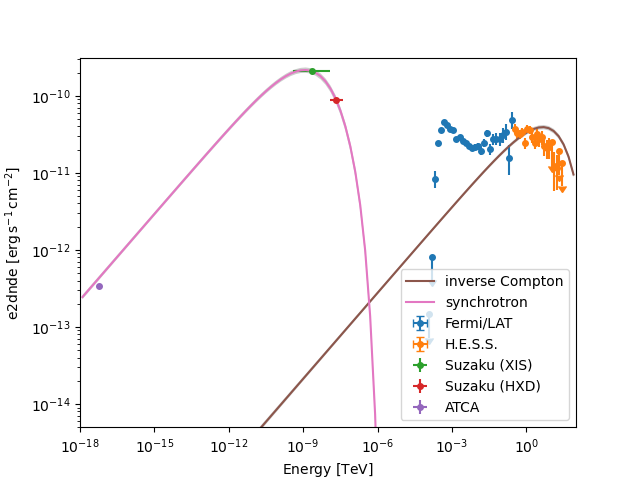

The model still does not describe the data well. We can check the magnetic field for this model:

In [ ]:
B = model_sync.parameters['B'].quantity
Berr = model_sync.parameters['B'].error * model_sync.parameters['B'].unit

In [ ]:
print('The magnetic field is B = {:3.1f} +/- {:2.1f}'.format(B, Berr))

### Lepto-Hadronic Model

We have seen in the last plot that we do not really succeed in building a model that describes all data with synchrotron radiation and inverse Compton emission. The publication that is cited above uses a more complicated model where the electron spectrum has a break (or turn-over) between radio and X-ray points. 

We will try something different here. We know that there are electrons, because we see synchrotron radiation. We expect to see emission from protons, because supernova remnants are very good candidates for Cosmic-Ray acceleration. We will try to build a model including leptonic and hadronic emission.

**Exercise**

Build a model that combined the leptonic model with the hadronic model. Take a look again how this was done to create the leptonic model. You build a ```CompoundSpectralModel``` that adds the spectral models of ```model_leptonic``` and ```model_hadronic```. This will be your spectral model in a SkyModel. Your model ```model_combined``` should be a ```SkyModel```. Do not set any paramters equal to others! We need that only for the leptonic model, and there it is done already.

In [ ]:
# your code here

model_combined = ...

In [ ]:
print(model_combined)

Expected output:

```
SkyModel

  Name                      : lepto-hadronic model
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    amplitude                     :   6.49e+36   +/- 3.0e+35 1 / eV      
    e_0                   (frozen):      0.100       TeV         
    alpha                         :      2.256   +/-    0.01             
    e_cutoff                      :     89.881   +/-    2.55 TeV         
    beta                  (frozen):      1.000                   
    B                             :      6.028   +/-    0.12 uG          
    amplitude                     :   6.49e+36   +/- 3.0e+35 1 / eV      
    e_0                   (frozen):      0.100       TeV         
    alpha                         :      2.256   +/-    0.01             
    e_cutoff                      :     89.881   +/-    2.55 TeV         
    beta                  (frozen):      1.000                   
    amplitude                     :   6.94e+36   +/- 2.6e+35 1 / eV      
    e_0                   (frozen):      1.000       TeV         
    alpha                         :      1.934   +/-    0.03             
    e_cutoff                      :    145.198   +/-   52.62 TeV         
    beta                  (frozen):      1.000   
```

Correct model created: **[5 marks]**

**Exercise**

Assign the model do ```all_datasets``` and perform the fit. The fit may produce a lot of warnings which you can ignore. But you need to check the final output to make sure that the fit succeeds. You may need to re-run the fit several times.

In [ ]:
# your code here

Fit succeeded: **[2 marks]**

In [ ]:
all_datasets.models.parameters.to_table().show_in_notebook()

In [ ]:
PlotPoints()

PlotModel(model_sync)
PlotModel(model_IC)
PlotModel(model_hadronic)

plt.legend(loc = 'upper left')

#plt.savefig('Modelling_FinalSED.png')

Expected output:

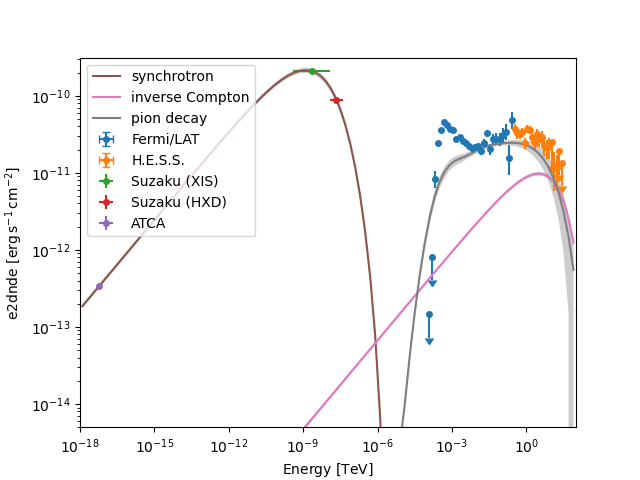

## Discussion

We can now take a look at what we found out.

In the above plot you see that the gamma-ray emission is dominated by emission from protons. The hadronic model is rather flat. The inverse-Compton model is very low, probably too low to be measured on its own. You also see that the shape of the inverse-Compton model is similar to the shape of the synchrotron model.

In [ ]:
B = model_sync.parameters['B'].quantity
Berr = model_sync.parameters['B'].error * model_sync.parameters['B'].unit

print('The magnetic field is B = {:3.1f} +/- {:3.1f}'.format(B, Berr))

The magnetic field is a bit low. We would expect something in the range of a few hundred micro-Gauss.

In [ ]:
Ecut_protons = model_hadronic.parameters['e_cutoff'].quantity
Ecut_protons_err = model_hadronic.parameters['e_cutoff'].error * model_hadronic.parameters['e_cutoff'].unit

print('The cut-off energy of the protons is Ecut = {:3.0f} +/- {:3.0f}'.format(Ecut_protons, Ecut_protons_err))

The proton spectrum cuts off around 100 TeV. We are still searching for Cosmic-Ray sources that extend up to 1000 TeV. RX J1713 is not one of those so-called PeVatrons.

In [ ]:
print('The total energy in protons is W_p = {:2.1e} '\
      'which is {:2.0f}% of the supernova explosion energy of 1e51 erg'.
      format(hadronic.Wp, hadronic.Wp/(1e51*u.erg)*100))

We expect about 10% of the explosion energy being converted into gamma rays.

## Sanity Check

Before you submit your work you should make a few checks that everything works fine.

1. Save your notebook as a PDF (File->Save and Export Notebook As->PDF). This document will help you debugging in the next step.
1. If you had to run the fits multiple times it would be good to have multiple runs in the notebook, so that you don't need to do it by hand again.
1. Restart the kernel and rerun the entire notebook (Kernel->Restart & Run All). This will delete all variables (but not your code) and rerun the notebook in one go. If this does not go through the end (i.e. you do not see the output of the next cell) then you have to fix it. You will see at which cell the run stopped. A common mistake is using a variable that is defined only at a later stage.
1. You think you fixed everything? Redo step 2 (Kernel->Restart & Run All)

In [ ]:
print('a\bYa\boa\bua\b a\baa\bra\bea\b a\bra\bea\baa\bda\bya\b a\bta\boa\b a\bsa\bua\bba\bma\bia\bta\b.a\b')

Do you see the output of the last cell without explicitly running it? Then the notebook goes through with one kernel restart. You can proceed to submission.
You do not see the output? Go back to step 2 above.

The jupyter notebook goes through all cells with one Kernel Restart & Run all.    **[1 mark]**

## Submission

You have to download and submit 2 files, the jupyter notebook and the two data files.
- Jupyter notebook. File->Download As->Notebook (.ipynb). Save this file on your disk.
- PDF (File->Save and Export Notebook As->PDF)

Congratulations. You have succesfully build a model to describe the spectral energy distribution of RX J1713.